In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

from src import (TFIDFRecommender, BM25Recommender, SemanticRecommender, HybridRecommender)
from src.evaluation import evaluate_retriever

load_dotenv()
hf_token = os.getenv('HF_TOKEN')

In [3]:
df = pd.read_pickle("../data/processed/en_movies_processed.pkl")
test_set = df.sample(2000, random_state=42)

## TF-IDF baseline

In [5]:
%%time
tfidf = TFIDFRecommender(
    df,
    use_lemmatization=True,
    remove_stopwords=True,
    ngram_range=(1,2),
    min_length=2,
    use_alpha_filter=True
)
tfidf.fit()

CPU times: user 24.3 s, sys: 747 ms, total: 25.1 s
Wall time: 26.4 s


In [6]:
query_title = "Captain America: Civil War"
query_info = df[df['original_title'] == query_title].iloc[0]

print(f"Query: {query_title}")
print(f"Genres: {query_info['genres_list']}")
print(f"Plot: {query_info['overview'][:150]}...\n")

recs = tfidf.recommend(query_title, top_k=5)
recs

Query: Captain America: Civil War
Genres: ['Adventure', 'Action', 'Science Fiction']
Plot: Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarize...



,original_title,similarity_score,genres_list,overview
85,Captain America: The Winter Soldier,0.193446,"[Action, Adventure, Science Fiction]",After the cataclysmic events in New York with ...
168,Captain America: The First Avenger,0.134787,"[Action, Adventure, Science Fiction]","Predominantly set during World War II, Steve R..."
7,Avengers: Age of Ultron,0.079683,"[Action, Adventure, Science Fiction]",When Tony Stark tries to jumpstart a dormant p...
79,Iron Man 2,0.068125,"[Adventure, Action, Science Fiction]",With the world now aware of his dual life as t...
648,This Means War,0.065424,"[Action, Comedy, Romance]",Two top CIA operatives wage an epic battle aga...


## BM25

In [7]:
%%time
bm25 = BM25Recommender(
    df,
    k1=1.5,
    b=0.75,
    use_lemmatization=True,
    remove_stopwords=True,
    ngram_range=(1,1),
    min_length=2,
    use_alpha_filter=True
)
bm25.fit()

CPU times: user 1min 14s, sys: 1.83 s, total: 1min 16s
Wall time: 1min 18s


In [8]:
print(f"Query: {query_title}")
print(f"Genres: {query_info['genres_list']}")
print(f"Plot: {query_info['overview'][:150]}...\n")

recs = bm25.recommend(query_title, top_k=5)
recs

Query: Captain America: Civil War
Genres: ['Adventure', 'Action', 'Science Fiction']
Plot: Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarize...



,original_title,similarity_score,genres_list,overview
85,Captain America: The Winter Soldier,35.743016,"[Action, Adventure, Science Fiction]",After the cataclysmic events in New York with ...
168,Captain America: The First Avenger,28.876068,"[Action, Adventure, Science Fiction]","Predominantly set during World War II, Steve R..."
7,Avengers: Age of Ultron,22.626783,"[Action, Adventure, Science Fiction]",When Tony Stark tries to jumpstart a dormant p...
2601,An American Haunting,18.799551,"[Horror, Thriller]",Based on the true events of the only case in U...
2474,Lawrence of Arabia,17.999958,"[Adventure, Drama, History, War]",An epic about British officer T.E. Lawrence's ...


## Semantic (EmbeddingGemma)

In [9]:
%%time
semantic = SemanticRecommender(df, model_name="google/embeddinggemma-300m", token=hf_token)
semantic.encode_all()

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

CPU times: user 17.8 s, sys: 19.7 s, total: 37.5 s
Wall time: 2min 17s


In [10]:
print(f"Query: {query_title}")
print(f"Genres: {query_info['genres_list']}")
print(f"Plot: {query_info['overview'][:150]}...\n")

recs = semantic.recommend(query_title, top_k=5)
recs

Query: Captain America: Civil War
Genres: ['Adventure', 'Action', 'Science Fiction']
Plot: Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarize...



,original_title,similarity_score,genres_list,overview
7,Avengers: Age of Ultron,0.591021,"[Action, Adventure, Science Fiction]",When Tony Stark tries to jumpstart a dormant p...
85,Captain America: The Winter Soldier,0.489445,"[Action, Adventure, Science Fiction]",After the cataclysmic events in New York with ...
16,The Avengers,0.484597,"[Science Fiction, Action, Adventure]",When an unexpected enemy emerges and threatens...
9,Batman v Superman: Dawn of Justice,0.458277,"[Action, Adventure, Fantasy]",Fearing the actions of a god-like Super Hero l...
79,Iron Man 2,0.453534,"[Adventure, Action, Science Fiction]",With the world now aware of his dual life as t...


## Hybrid (BM25 + semantic)

In [11]:
hybrid = HybridRecommender(bm25, semantic, alpha=0.5)

In [12]:
print(f"Query: {query_title}")
print(f"Genres: {query_info['genres_list']}")
print(f"Plot: {query_info['overview'][:150]}...\n")

recs = hybrid.recommend(query_title, top_k=5)
recs

Query: Captain America: Civil War
Genres: ['Adventure', 'Action', 'Science Fiction']
Plot: Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarize...



,original_title,similarity_score,genres_list,overview
7,Avengers: Age of Ultron,0.372310,"[Action, Adventure, Science Fiction]",When Tony Stark tries to jumpstart a dormant p...
85,Captain America: The Winter Soldier,0.364855,"[Action, Adventure, Science Fiction]",After the cataclysmic events in New York with ...
168,Captain America: The First Avenger,0.313230,"[Action, Adventure, Science Fiction]","Predominantly set during World War II, Steve R..."
79,Iron Man 2,0.281698,"[Adventure, Action, Science Fiction]",With the world now aware of his dual life as t...
16,The Avengers,0.276166,"[Science Fiction, Action, Adventure]",When an unexpected enemy emerges and threatens...


In [13]:
tfidf_scores = evaluate_retriever(tfidf, test_set, k_values=[5, 10])
bm25_scores = evaluate_retriever(bm25, test_set, k_values=[5, 10])
semantic_scores = evaluate_retriever(semantic, test_set, k_values=[5, 10])
hybrid_scores = evaluate_retriever(hybrid, test_set, k_values=[5, 10])

## Results comparison

In [14]:
results_df = pd.DataFrame([
    {'method': 'TF-IDF', **tfidf_scores},
    {'method': 'BM25', **bm25_scores},
    {'method': 'Semantic', **semantic_scores},
    {'method': 'Hybrid', **hybrid_scores}
])

print(results_df[['method', 'precision@5', 'precision@10', 'jaccard@5', 'content_div@5', 'query_time_ms']].to_string(index=False))

  method  precision@5  precision@10  jaccard@5  content_div@5  query_time_ms
  TF-IDF       0.6689       0.65355   0.291547       0.769520       3.149382
    BM25       0.6880       0.66755   0.303833       0.764817       3.241188
Semantic       0.8127       0.80325   0.397303       0.715280       3.335040
  Hybrid       0.7901       0.77940   0.382001       0.718064       3.145389


In [15]:
results_df.to_csv('../data/results/method_comparison.csv', index=False)

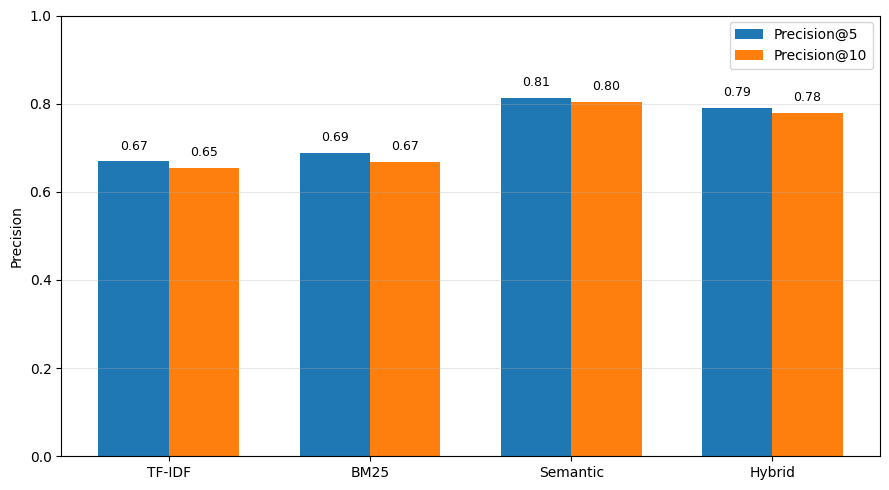

In [16]:
fig, ax = plt.subplots(figsize=(9, 5))

methods = results_df['method']
x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['precision@5'], width, label='Precision@5')
bars2 = ax.bar(x + width/2, results_df['precision@10'], width, label='Precision@10')

ax.set_ylabel('Precision')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}',
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../data/results/method_comparison_precision@5-10.png', dpi=150, bbox_inches='tight')
plt.show()

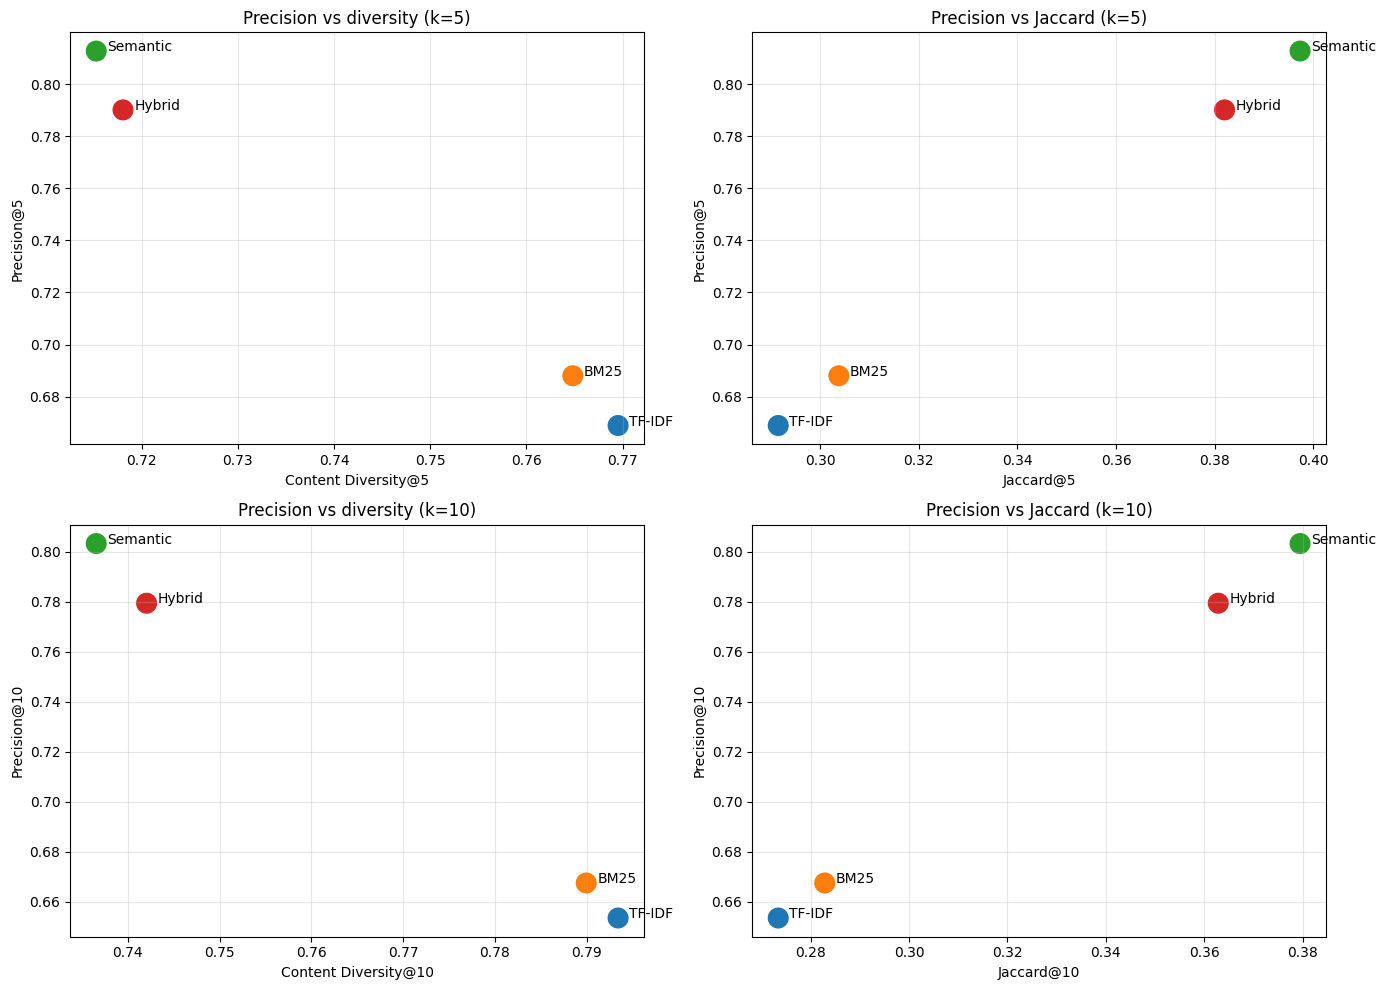

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ax = axes[0, 0]
ax.scatter(results_df['content_div@5'], results_df['precision@5'], s=200, c=colors)
for i, row in results_df.iterrows():
    ax.annotate(row['method'],
                (row['content_div@5'], row['precision@5']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Content Diversity@5')
ax.set_ylabel('Precision@5')
ax.set_title('Precision vs diversity (k=5)')
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.scatter(results_df['jaccard@5'], results_df['precision@5'], s=200, c=colors)
for i, row in results_df.iterrows():
    ax.annotate(row['method'],
                (row['jaccard@5'], row['precision@5']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Jaccard@5')
ax.set_ylabel('Precision@5')
ax.set_title('Precision vs Jaccard (k=5)')
ax.grid(alpha=0.3)

ax = axes[1, 0]
ax.scatter(results_df['content_div@10'], results_df['precision@10'], s=200, c=colors)
for i, row in results_df.iterrows():
    ax.annotate(row['method'],
                (row['content_div@10'], row['precision@10']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Content Diversity@10')
ax.set_ylabel('Precision@10')
ax.set_title('Precision vs diversity (k=10)')
ax.grid(alpha=0.3)

ax = axes[1, 1]
ax.scatter(results_df['jaccard@10'], results_df['precision@10'], s=200, c=colors)
for i, row in results_df.iterrows():
    ax.annotate(row['method'],
                (row['jaccard@10'], row['precision@10']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Jaccard@10')
ax.set_ylabel('Precision@10')
ax.set_title('Precision vs Jaccard (k=10)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/results/method_comparison_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## Add keywords to input

In [4]:
df['content'] = df['original_title'] + ': ' + df['overview'] + ' ' + df['keywords_list'].apply(lambda x: ', '.join(x))

In [5]:
%%time
tfidf = TFIDFRecommender(
    df,
    use_lemmatization=True,
    remove_stopwords=True,
    ngram_range=(1,2),
    min_length=2,
    use_alpha_filter=True
)
tfidf.fit()

CPU times: user 26.3 s, sys: 378 ms, total: 26.7 s
Wall time: 26.8 s


In [6]:
%%time
bm25 = BM25Recommender(
    df,
    k1=1.5,
    b=0.75,
    use_lemmatization=True,
    remove_stopwords=True,
    ngram_range=(1,1),
    min_length=2,
    use_alpha_filter=True
)
bm25.fit()

CPU times: user 1min 30s, sys: 541 ms, total: 1min 31s
Wall time: 1min 31s


In [7]:
%%time
semantic = SemanticRecommender(df, model_name="google/embeddinggemma-300m", token=hf_token)
semantic.encode_all()

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

CPU times: user 19.2 s, sys: 12.3 s, total: 31.5 s
Wall time: 2min 38s


In [8]:
hybrid = HybridRecommender(bm25, semantic, alpha=0.5)

In [9]:
tfidf_scores_with_keywords = evaluate_retriever(tfidf, test_set, k_values=[5, 10])
bm25_scores_with_keywords = evaluate_retriever(bm25, test_set, k_values=[5, 10])
semantic_scores_with_keywords = evaluate_retriever(semantic, test_set, k_values=[5, 10])
hybrid_scores_with_keywords = evaluate_retriever(hybrid, test_set, k_values=[5, 10])

In [10]:
results_df_keywords = pd.DataFrame([
    {'method': 'TF-IDF', **tfidf_scores_with_keywords},
    {'method': 'BM25', **bm25_scores_with_keywords},
    {'method': 'Semantic', **semantic_scores_with_keywords},
    {'method': 'Hybrid', **hybrid_scores_with_keywords}
])

print(results_df_keywords[['method', 'precision@5', 'precision@10', 'jaccard@5', 'content_div@5', 'query_time_ms']].to_string(index=False))

  method  precision@5  precision@10  jaccard@5  content_div@5  query_time_ms
  TF-IDF       0.7297        0.7101   0.332386       0.730202       3.347761
    BM25       0.7546        0.7355   0.353663       0.730525       3.493509
Semantic       0.8333        0.8234   0.414954       0.694845       3.032410
  Hybrid       0.8194        0.8116   0.405386       0.692155       3.141087


In [ ]:
results_df_keywords.to_csv('../data/results/method_comparison_with_keywords.csv', index=False)

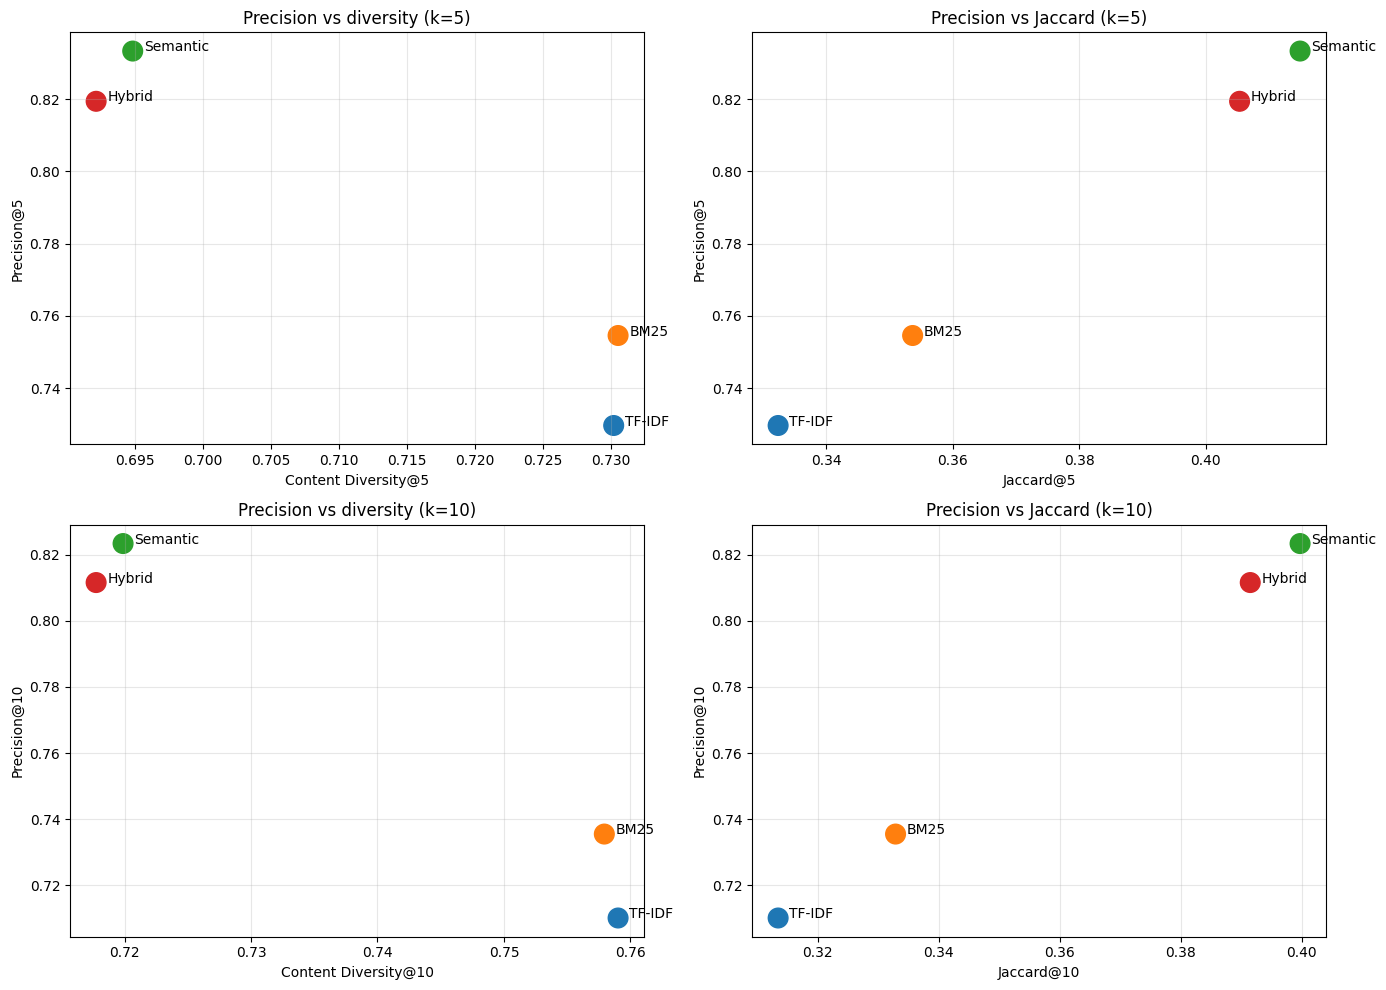

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ax = axes[0, 0]
ax.scatter(results_df_keywords['content_div@5'], results_df_keywords['precision@5'], s=200, c=colors)
for i, row in results_df_keywords.iterrows():
    ax.annotate(row['method'],
                (row['content_div@5'], row['precision@5']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Content Diversity@5')
ax.set_ylabel('Precision@5')
ax.set_title('Precision vs diversity (k=5)')
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.scatter(results_df_keywords['jaccard@5'], results_df_keywords['precision@5'], s=200, c=colors)
for i, row in results_df_keywords.iterrows():
    ax.annotate(row['method'],
                (row['jaccard@5'], row['precision@5']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Jaccard@5')
ax.set_ylabel('Precision@5')
ax.set_title('Precision vs Jaccard (k=5)')
ax.grid(alpha=0.3)

ax = axes[1, 0]
ax.scatter(results_df_keywords['content_div@10'], results_df_keywords['precision@10'], s=200, c=colors)
for i, row in results_df_keywords.iterrows():
    ax.annotate(row['method'],
                (row['content_div@10'], row['precision@10']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Content Diversity@10')
ax.set_ylabel('Precision@10')
ax.set_title('Precision vs diversity (k=10)')
ax.grid(alpha=0.3)

ax = axes[1, 1]
ax.scatter(results_df_keywords['jaccard@10'], results_df_keywords['precision@10'], s=200, c=colors)
for i, row in results_df_keywords.iterrows():
    ax.annotate(row['method'],
                (row['jaccard@10'], row['precision@10']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Jaccard@10')
ax.set_ylabel('Precision@10')
ax.set_title('Precision vs Jaccard (k=10)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/results/method_comparison_scatter_with_keywords.png', dpi=150, bbox_inches='tight')
plt.show()

### Keyword impact

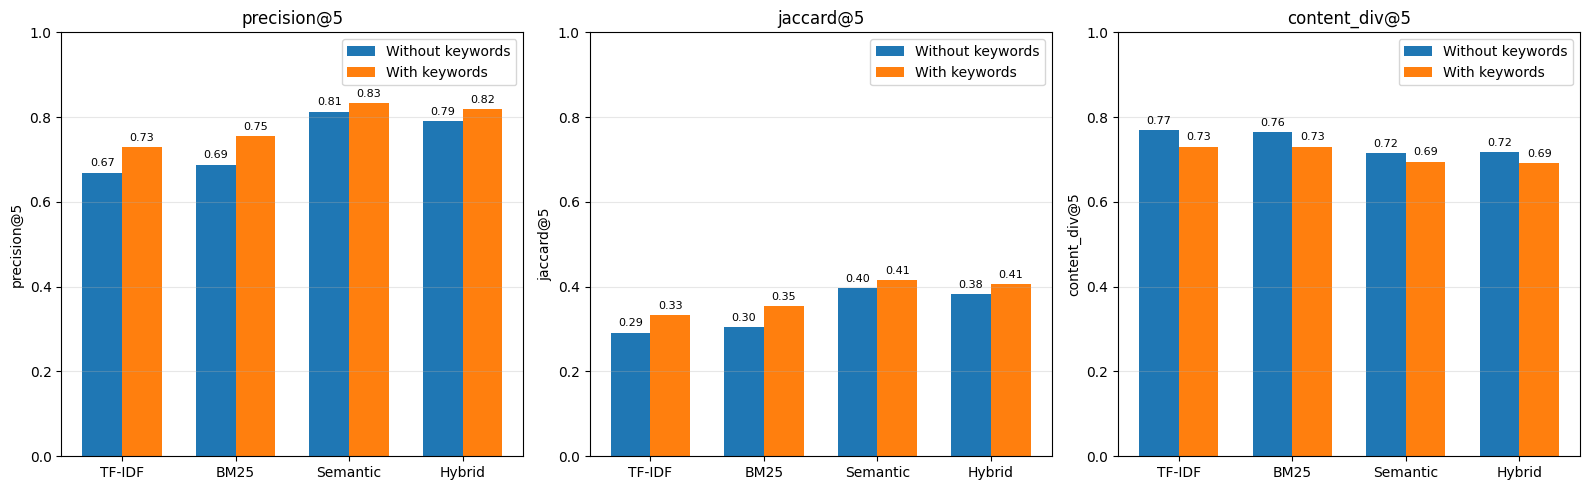

In [12]:
df_base = pd.read_csv('../data/results/method_comparison.csv')
df_kw = pd.read_csv('../data/results/method_comparison_with_keywords.csv')

methods = df_base['method'].tolist()


fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['precision@5', 'jaccard@5', 'content_div@5']

x = np.arange(len(methods))
width = 0.35

for ax, metric in zip(axes, metrics):
    bars1 = ax.bar(x - width/2, df_base[metric], width, label='Without keywords')
    bars2 = ax.bar(x + width/2, df_kw[metric], width, label='With keywords')

    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    ax.set_title(metric)

    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../data/results/method_keywords_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
